### Welcome to the [Data-driven Methods for Network-level Coordination of Autonomous Mobility-on-Demand Systems Across Scales](https://rl4amod-itsc24.github.io/) coding tutorial, presented at 27th IEEE ITSC 2024

<img src="figures/gnn-for-amod.png" width="700"/></td> <br/>

Join us in moving the first steps toward the creation of publicly available benchmarks, datasets, and simulators for network-level coordination of MoD systems.

This notebook offers an interactive, hands-on session for benchmarking AMoD controllers across 
- openly accessible simulation platforms across different fidelity levels 
- calibareted scenarios calibrat 
- Implementation of fleet coordination algorithms

### Installation of required packages

In [2]:
!pip install hydra-core

In [3]:
!pip install PuLP

In [4]:
!pip install torch_geometric

In [5]:
!pip install traci

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [traci]32m1/2 [traci]


### Clone the repository

In [ ]:
!git clone https://github.com/StanfordASL/RL4AMOD

In [ ]:
cd RL4AMOD

### 1. The macro environment 

The macro envorinment is based on taxi record data colleted in various city, e.g. New York City, San Francisco, Washignton DC, Shenzhen. In each scenarion, the road network is segmented into stations by clustering junctions such that the travel time within each station is upper-bounded by a given error tolerance. 

In this notebook, we are looking at the nyc brooklyn scenario. It exists of 14 clustered regions with the following demand distribution: 

<img src="figures/demand_profit.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="800"/>


## 2. Baselines

This repository provides a set of baseline policies, that aim to outperform the no-control policy, which serves as the lower bound. 
The simplest of these is the random rebalancing policy. We evaluate its performance against the no-control policy by assessing total profit, calculated as the profit from passengers served minus the cost of rebalancing.

In [1]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

3.10.3
3.10.3


<module 'testing' from '/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/testing.py'>

/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model random on macro environment


Test Episode 10 | Reward: 25908.27 | ServedDemand: 48274.27 | Reb. Cost: 22366.00: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Mean Episode Profit ($):  26514.616038757482
Mean Episode Served Demand- Proit($):  47728.61603875748
Mean Episode Rebalancing Cost($):  21214.0


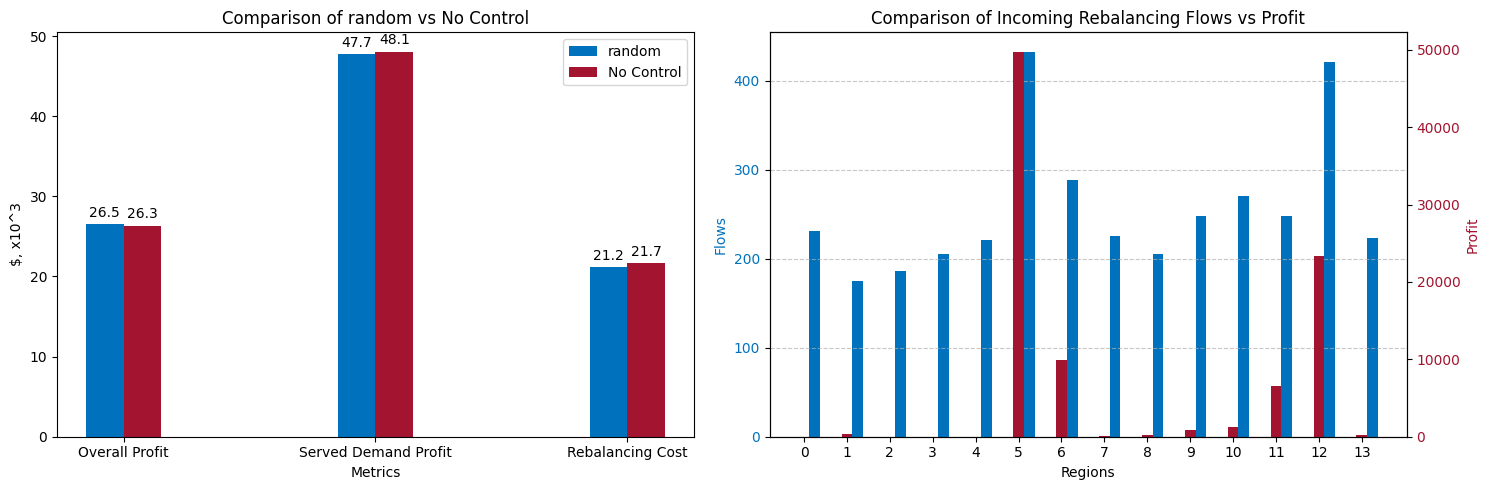

In [19]:
importlib.reload(testing)
config = {
    "simulator.name": "macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
!pwd
testing.test(config)

It’s no surprise that the random rebalancing policy fails to outperform the no-control policy. As shown in the figure on the right, it tends to relocate many vehicles to low-demand regions, resulting in inefficient rebalancing.

### Implement your own controller

The random rebalancing policy is not able to outperform the no control baseline, so let's implement a policy that does. We can develop a control policy that aims to achieve an equal distribution of vehicles across the network while minimizing rebalancing costs.

In [20]:
from src.misc.utils import dictsum
from src.algos.reb_flow_solver import solveRebFlow
from src.algos.base import BaseAlgorithm


class EqualDistribution(BaseAlgorithm):
    def __init__(self, **kwargs):
        """
        :param cplexpath: Path to the CPLEX solver.
        """
        self.cplexpath = kwargs.get('cplexpath') #None, for no CPLEX

    def select_action(self, env):
        """
        Implements the Equal Distribution (ED) baseline for rebalancing.
        :param env: The current state of the environment
        :return: The rebalancing action to be taken
        """
        # number of regions in this scenario
        nregions = env.nregion
        
        #determines the desired vehicle distirbutions
        action = [1 / nregions for _ in range(nregions)]
        
        #calculates the desired number of vehicles in each region
        desired_acc = {
            env.region[i]: int(action[i] * dictsum(env.acc, env.time +1))
            for i in range(len(env.region))
        }
        
        #calculated the min-cost rebalancing flow to reach desried distirbution
        reb_action = solveRebFlow(env, desired_acc, self.cplexpath) 
        
        return reb_action

Now we can test this new policy and compare it to the no control baseline: 

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model equal_distribution on macro environment


Test Episode 10 | Reward: 51187.48 | ServedDemand: 60633.48 | Reb. Cost: 9446.00: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Mean Episode Profit ($):  50391.579833459386
Mean Episode Served Demand- Proit($):  59899.97983345939
Mean Episode Rebalancing Cost($):  9508.4


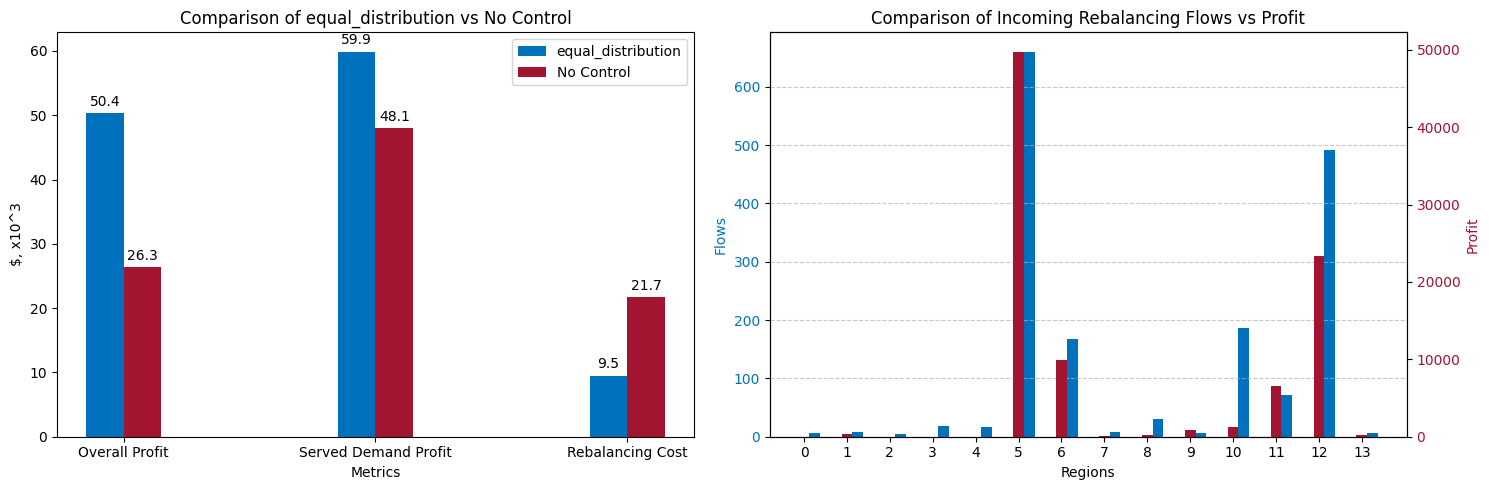

In [21]:
config = {
    "simulator.name": "macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

While the equal distribution policy significantly boosts profit compared to the no-control baseline, the rebalancing flows still don't align entirely with the demand distribution. (e.g. region 10 and 12)

## 3. RL-based policies 

Although the equal distribution policy already significantly outperforms the no-control baseline, it remains a reactive approach. Instead of relying on a policy that enforces an equal distribution of idle vehicles, we can implement a reinforcement learning (RL) policy that proactively adjusts the distribution based on the current state. 

In this repository, we already provide a pre-trained agent: 

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 10 | Reward: 55617.67 | ServedDemand: 68765.67 | Reb. Cost: 13148.00: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Mean Episode Profit ($):  55384.34110172365
Mean Episode Served Demand- Proit($):  68469.94110172367
Mean Episode Rebalancing Cost($):  13085.6


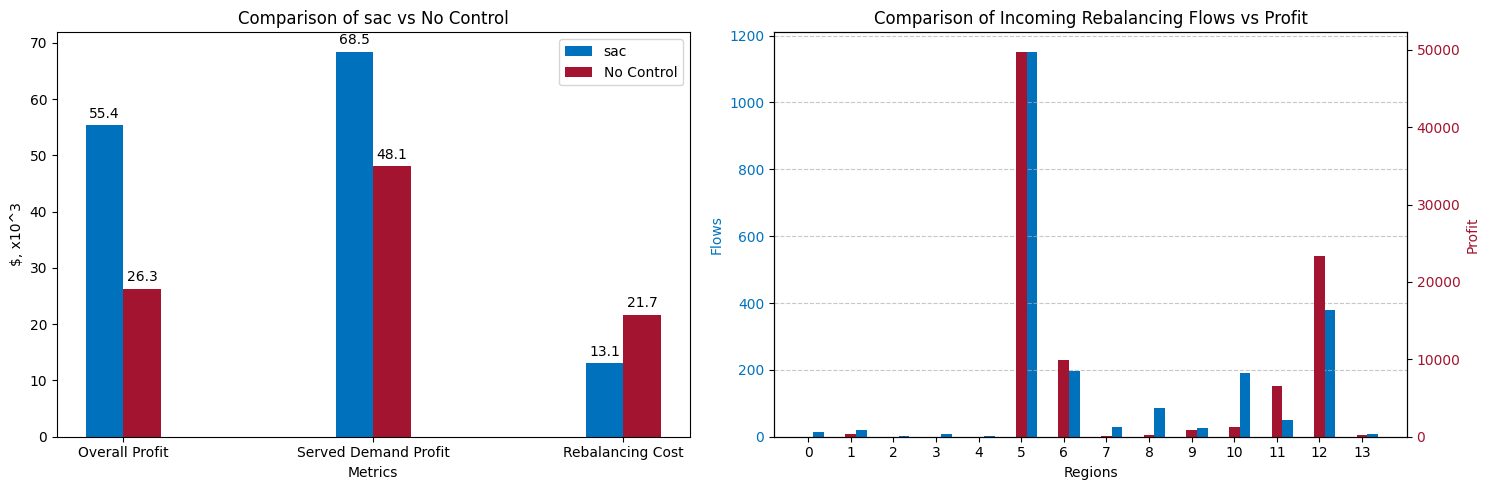

In [22]:
# from testing import test
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn"
}
testing.test(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on multi_macro environment


Test Episode 10 | Reward: 10560.88 | ServedDemand: 22878.88 | Reb. Cost: 12318.00: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Mean Episode Profit ($):  10275.921536796537
Mean Episode Served Demand- Proit($):  22643.721536796536
Mean Episode Rebalancing Cost($):  12367.8


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 15691.37 | ServedDemand: 25177.37 | Reb. Cost: 9486.00: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Mean Episode Profit ($):  16039.28057575758
Mean Episode Served Demand- Proit($):  24977.480575757578
Mean Episode Rebalancing Cost($):  8938.2


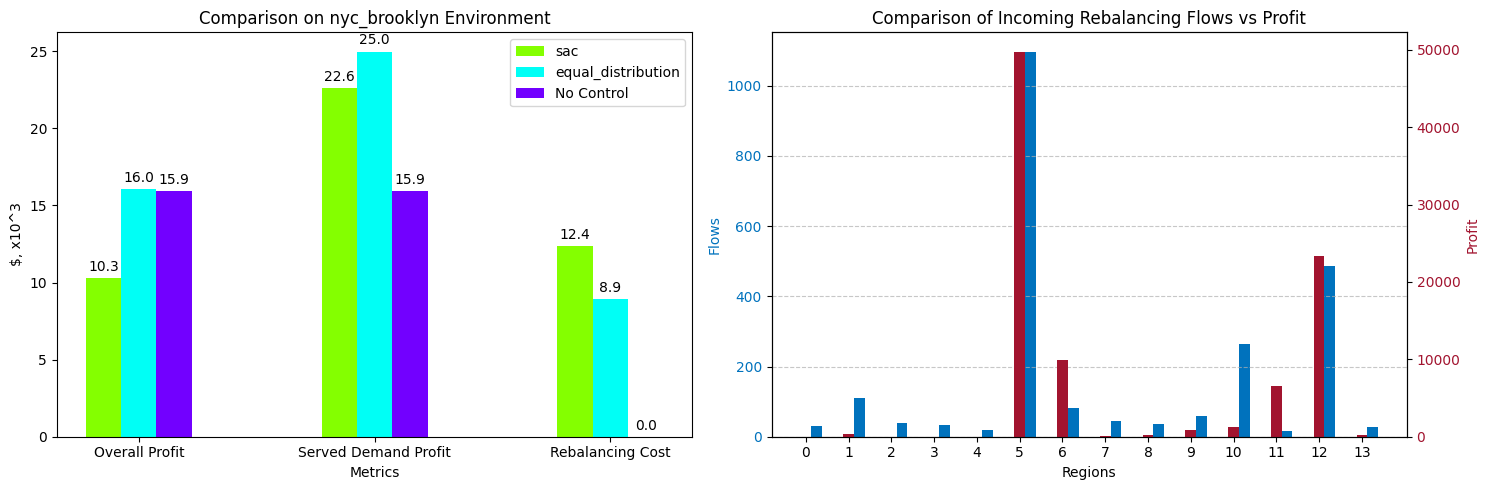

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn",
    "reuse": "False",
    "firms count": 1
}
testing.multi_test(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 15691.37 | ServedDemand: 25177.37 | Reb. Cost: 9486.00: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Mean Episode Profit ($):  16039.28057575758
Mean Episode Served Demand- Proit($):  24977.480575757578
Mean Episode Rebalancing Cost($):  8938.2


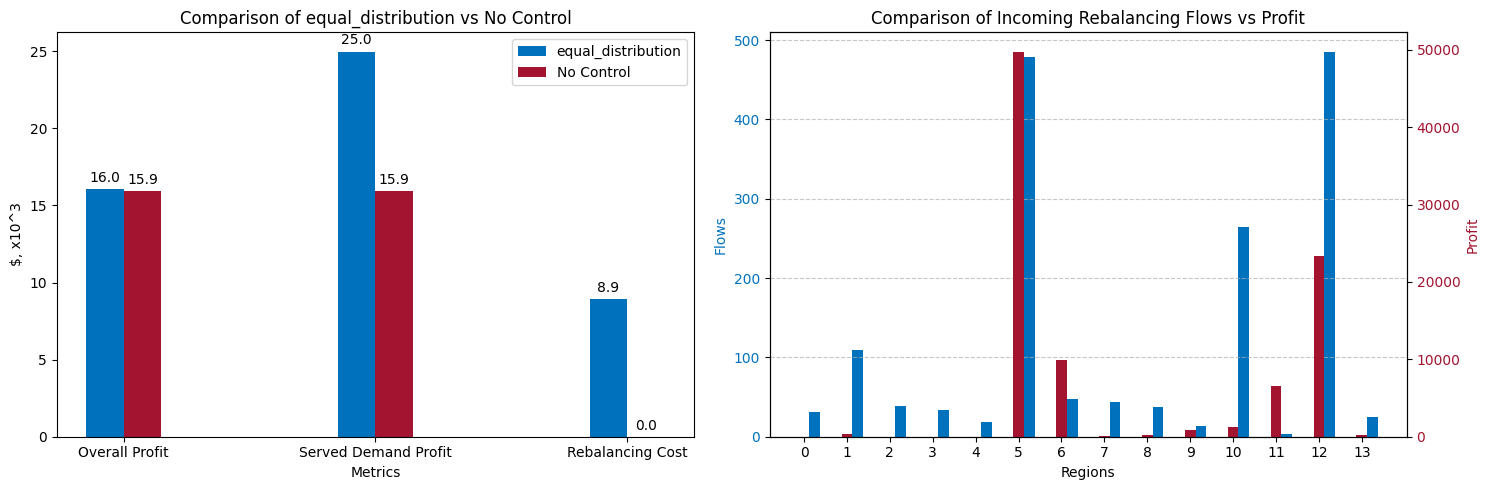

In [22]:
# With not changing x
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model random on multi_macro environment


Test Episode 10 | Reward: -9421.27 | ServedDemand: 19222.73 | Reb. Cost: 28644.00: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Mean Episode Profit ($):  -11768.51778138528
Mean Episode Served Demand- Proit($):  17955.48221861472
Mean Episode Rebalancing Cost($):  29724.0


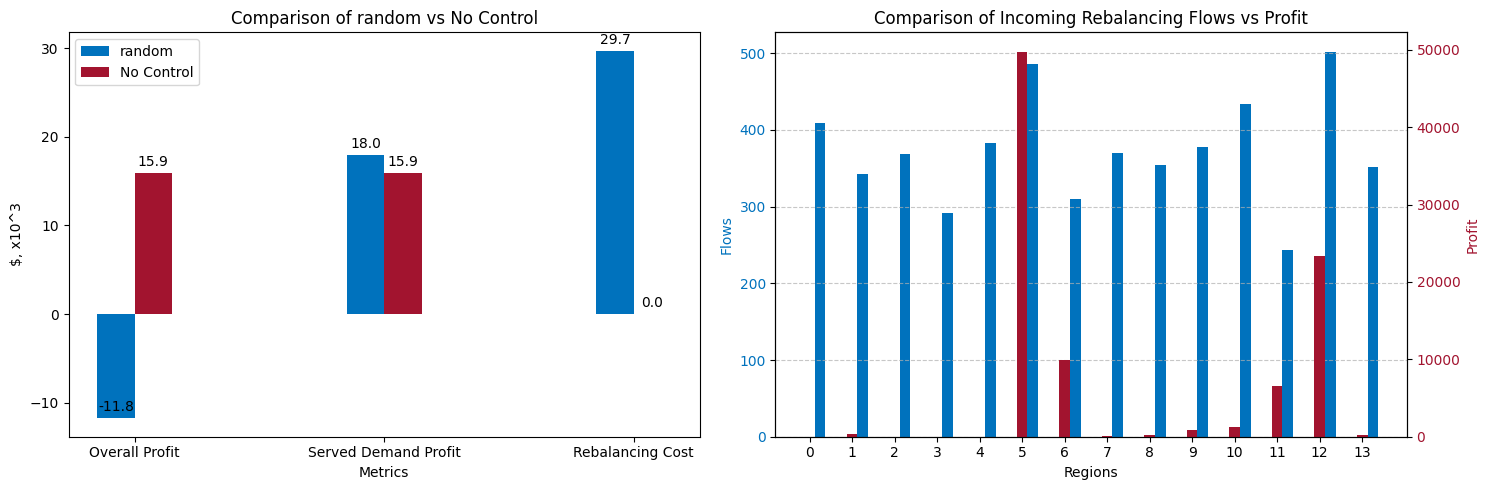

In [24]:
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

### Final comparison

<img src="figures/comparison_final.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="650"/>

## 4. Implement an RL agent

Generally policy takes the current state as input and outputs the next action $\pi(a_t | s_t)$:

<img src="figures/NN_Actor.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="200"/>

In [9]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Actor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, act_dim, hidden_size=32):
        super().__init__()
        """
        in_channels: state dimension
        act_dim: action dimension
        """
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, act_dim)
    
    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
    
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()

        return action

In [21]:
import torch
import matplotlib.pyplot as plt
'''
The state consits of 14 regions/nodes with 13 node features each
'''
state = torch.ones(14, 13) 

state = state.flatten() #MLP expects a vector input

actor = Actor(in_channels=14*13, act_dim=14)

action = actor(state)

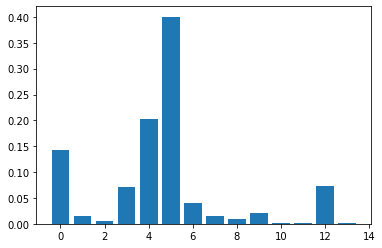

In [22]:
plt.bar(range(14), action.detach().numpy())
plt.show()

In [23]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet
from torch_geometric.nn import GCNConv


class GNNActor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, hidden_size=32, act_dim=6):
        super().__init__()
        self.in_channels = in_channels
        self.act_dim = act_dim
        self.conv1 = GCNConv(in_channels, in_channels)
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)

    def forward(self, state, edge_index):
        out = F.relu(self.conv1(state, edge_index))
        x = out + state
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
        
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()
           
        return action
    

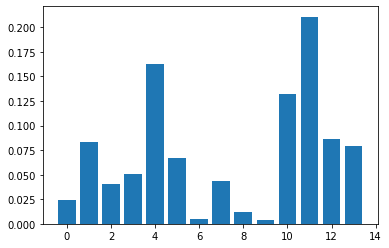

In [26]:
state = torch.ones(14, 13) 
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13],
                           [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12]])

actor = GNNActor(in_channels=13)

action = actor(state, edge_index)

plt.bar(range(14), action.detach().numpy())
plt.show()

### Train an RL agent

In [34]:
from train import train
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_custom",
    "model.max_episodes": 5,
}
train(config)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode 5 | Reward: 41567.10 | ServedDemand: 51921.60 | Reb. Cost: 10354.50: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 1 | Reward: 50202.84 | ServedDemand: 62232.84 | Reb. Cost: 12030.00: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Mean Episode Profit ($):  50202.835286798094
Mean Episode Served Demand- Proit($):  62232.835286798094
Mean Episode Rebalancing Cost($):  12030.0


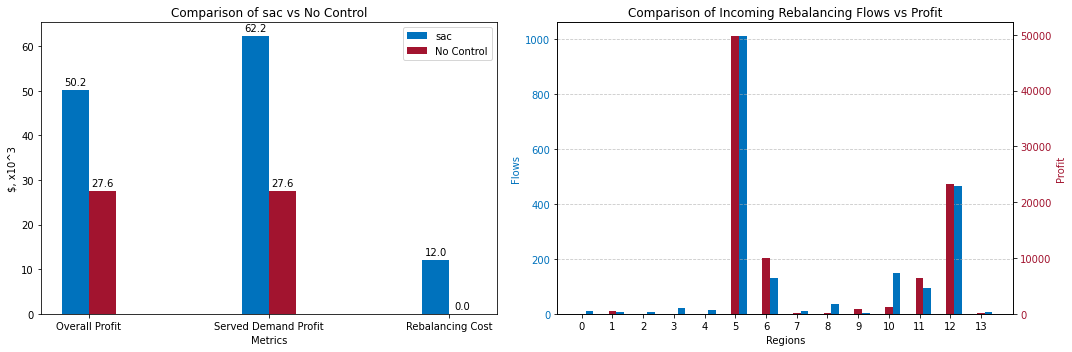

In [6]:
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_custom", #this will automatically load the best model checkpoint
    "model.test_episodes": 1,
}
test(config)

### Additional: SUMO Environment

The SUMO environment is built around a mesoscopic traffic simulator using the Simulation of Urban MObility (SUMO) framework. The available scenario is based on the city of Luxembourg, utilizing the LuST Scenario (https://github.com/lcodeca/lux), where the traffic demand has been derived from a calibrated trips file. To create a more simplified and abstract representation of the city, the road network has been spatially aggregated into 10 regions, resulting in a coarser graph of the urban landscape.

<img src="figures/lux_net.png" alt="drawing" width="500"/>    <img src="figures/lux_net_aggregated.png" alt="drawing" width="500"/>

In [ ]:
config = {
"simulator.name": "sumo",
"model.name": "mpc",
"simulator.city": "lux",
"model.cplexpath": None, 
"model.test_episodes": 1,
}
test(config)
